In [33]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math

# Data Loader

In [ ]:
# 1. Define transforms for data augmentation / normalization
batch_size = 64

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Only normalization for test
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

# 3. Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# Model

In [17]:
class EnhancedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)  # [N, 32, 16, 16]

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)  # [N, 64, 8, 8]

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)  # [N, 128, 4, 4]

        # Flatten
        x = x.view(x.size(0), -1) 

        # FC layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [38]:
model = EnhancedCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)

# Training

In [39]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward + Backward + Optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # Print average loss after each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/20], Loss: 2.1180
Epoch [2/20], Loss: 1.7105
Epoch [3/20], Loss: 1.4129
Epoch [4/20], Loss: 1.2530
Epoch [5/20], Loss: 1.1567
Epoch [6/20], Loss: 1.0866
Epoch [7/20], Loss: 1.0473
Epoch [8/20], Loss: 1.0134
Epoch [9/20], Loss: 0.9913
Epoch [10/20], Loss: 0.9581
Epoch [11/20], Loss: 0.9543
Epoch [12/20], Loss: 0.9319
Epoch [13/20], Loss: 0.9299
Epoch [14/20], Loss: 0.9052
Epoch [15/20], Loss: 0.8944
Epoch [16/20], Loss: 0.8920
Epoch [17/20], Loss: 0.8833
Epoch [18/20], Loss: 0.8758
Epoch [19/20], Loss: 0.8692
Epoch [20/20], Loss: 0.8743


# Eval

In [40]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")

Accuracy on test set: 70.91%


# Visualization

In [41]:
class_names = [
    'plane', 'car', 'bird', 'cat', 
    'deer', 'dog', 'frog', 'horse', 
    'ship', 'truck'
]

def imshow(img, mean, std):
    # img: shape (3, H, W)
    img = img.numpy().transpose((1, 2, 0))  # (H, W, 3)
    img = (img * std) + mean  # denormalize
    img = np.clip(img, 0, 1)  # clip to valid range
    return img

def visualize_predictions(model, test_loader, device, class_names, mean, std, num_images=20, cols=10):
    model.eval()

    # 1) Get one batch from the test loader
    dataiter = iter(test_loader)
    images, labels = next(dataiter)  # images shape: (B, 3, H, W)

    # 2) Slice out only the first 'num_images'
    images = images[:num_images]
    labels = labels[:num_images]

    # 3) Move to device
    images, labels = images.to(device), labels.to(device)

    # 4) Forward pass
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # shape: (num_images,)

    # 5) Move back to CPU for plotting
    images = images.cpu()
    labels = labels.cpu()
    preds = preds.cpu()

    # 6) Calculate rows automatically
    rows = math.ceil(num_images / cols)

    # 7) Create subplots with 'rows' x 'cols'
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(3*cols, 3*rows))
    fig.suptitle("Model Predictions", fontsize=16)
    
    # If we have just 1 row, axes is 1D; if more, axes is 2D
    axes = np.array(axes).reshape(rows, cols)  # ensures 2D even if rows=1

    # 8) Plot each image in a grid
    for i in range(num_images):
        row_idx = i // cols
        col_idx = i % cols

        ax = axes[row_idx, col_idx]
        
        # Denormalize the i-th image
        img = imshow(images[i], mean, std)  # your custom imshow function
        ax.imshow(img)
        
        title = f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}"
        ax.set_title(title, fontsize=9)
        ax.axis("off")

    # 9) Turn off any unused subplots if num_images < rows*cols
    for j in range(num_images, rows*cols):
        row_idx = j // cols
        col_idx = j % cols
        axes[row_idx, col_idx].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
    plt.show()

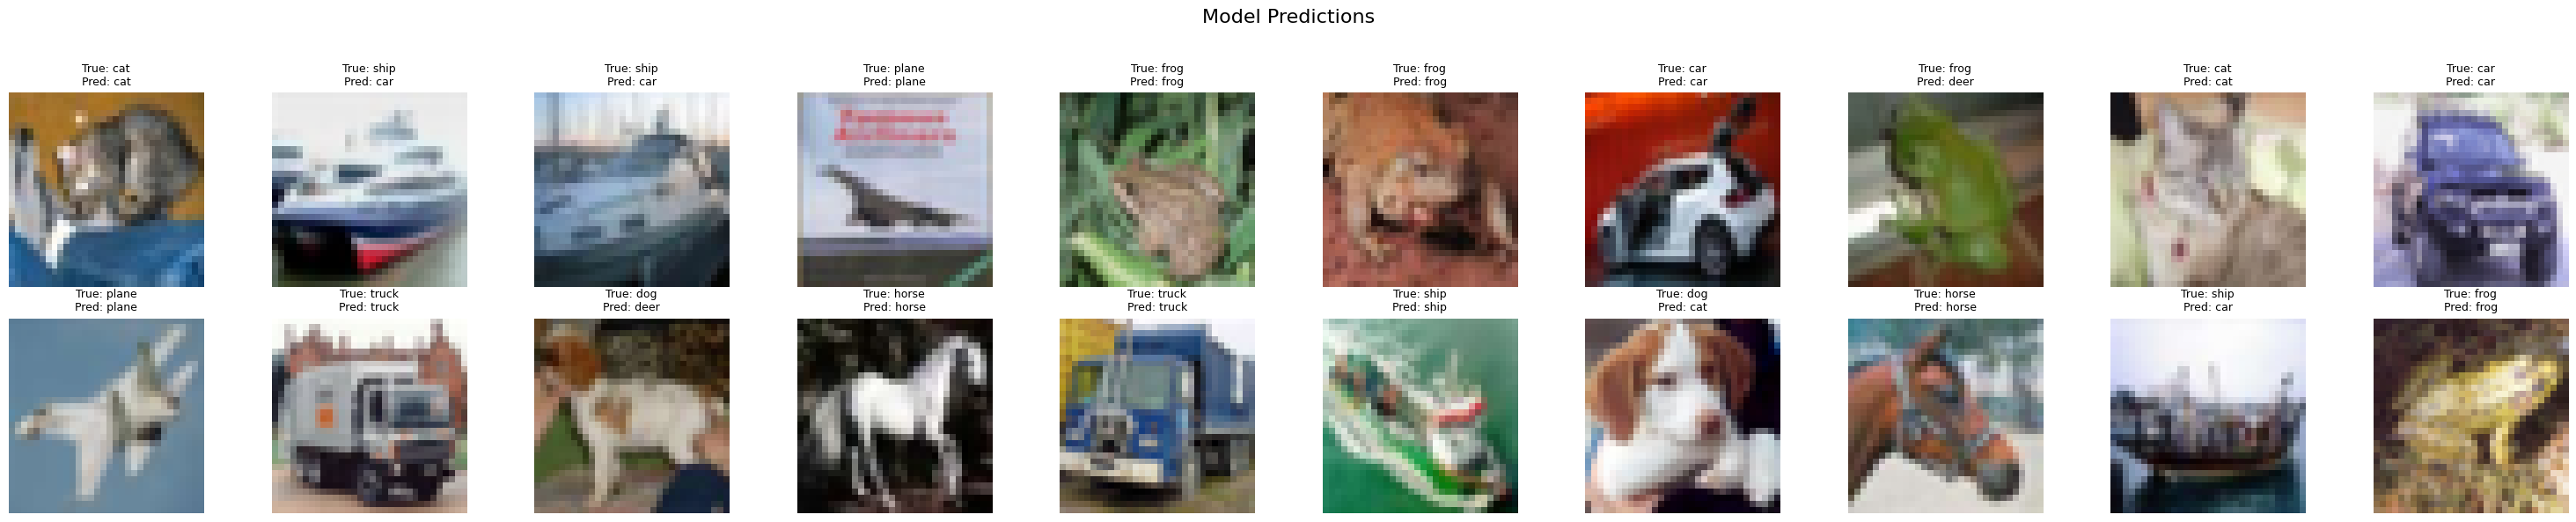

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

visualize_predictions(
    model, 
    test_loader, 
    device, 
    class_names=['plane', 'car', 'bird', 'cat', 
                 'deer', 'dog', 'frog', 'horse', 
                 'ship', 'truck'],
    mean=(0.5, 0.5, 0.5),
    std=(0.5, 0.5, 0.5),
    num_images=20
)
